[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/claresinger/PySDM-examples/blob/lowe_fig3/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/claresinger/PySDM-examples.git/lowe_fig3?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/claresinger/PySDM-examples/blob/lowe_fig3/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

#!pip install -e ~/Research/PySDM
import PySDM
print(PySDM.__file__)
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

/Users/claresinger/Research/PySDM/PySDM/__init__.py


In [11]:
CI = 'CI' in os.environ

updraft_list = np.geomspace(0.1, 10, 3 if CI else 6)
forg_list = np.linspace(0.05, 0.95, 3 if CI else 6)

#subplot_list = ["a","b","c","d"]
subplot_list = ["b"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "BDF":False
          }

In [14]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 0.01 * si.m,
            n_sd_per_mode = 50,
            model = model,
            aerosol = {
                "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            **consts
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 72
[ 0.1         0.25118864  0.63095734  1.58489319  3.98107171 10.        ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 10.1min finished


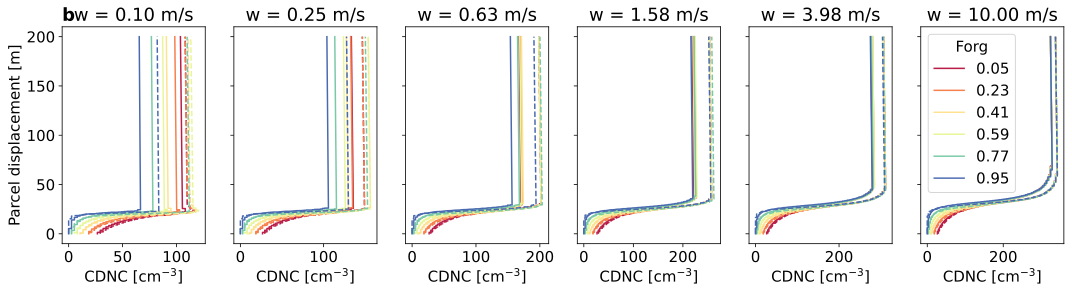

HTML(value="<a href='./fig3_parcel_profiles.pdf' target='_blank'>./fig3_parcel_profiles.pdf</a><br>")

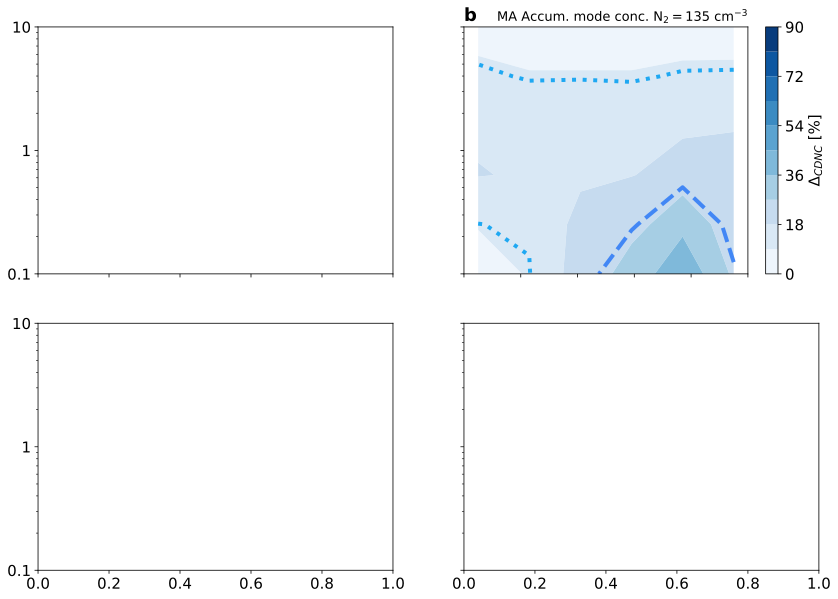

HTML(value="<a href='./fig_3.pdf' target='_blank'>./fig_3.pdf</a><br>")

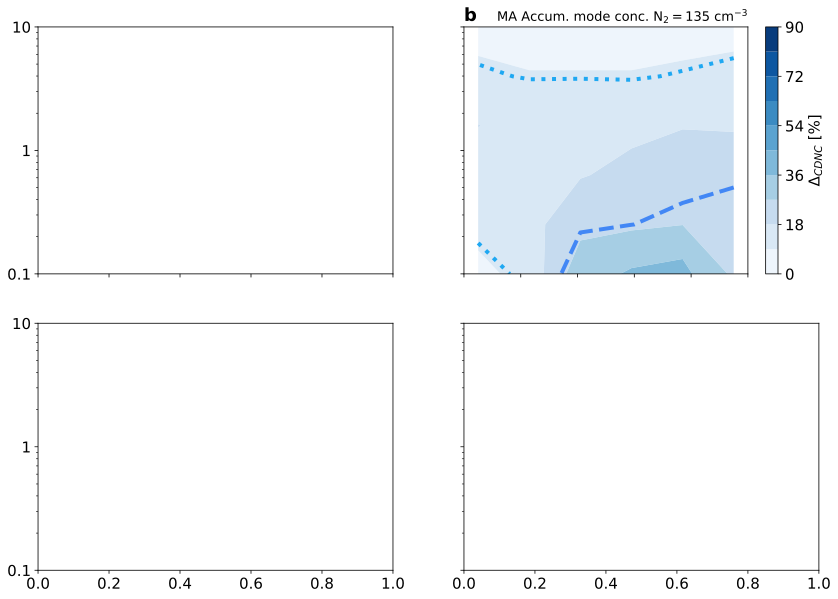

HTML(value="<a href='./fig_3_act_frac.pdf' target='_blank'>./fig_3_act_frac.pdf</a><br>")

In [15]:
from PySDM_examples.Lowe_et_al_2019.plot_helper import plot_profiles, plot_contours
plot_profiles(subplot_list, updraft_list, forg_list, output, save=True)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=False, save=True)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=True, save=True)